In [1]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision as models
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch.nn.functional as F
from datetime import datetime

plt.ion()   # interactive mode

In [2]:
lr = 0.001
epochs = 20
bs = 256

# dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
cpu = torch.device("cpu")
device = torch.device("cuda")

In [3]:
# https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
datadir = "data"
train_dir = "train"
val_dir = "val"

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=bs,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [4]:
def train_model(model, criterion, optimizer, scheduler, model_name, num_epochs=10):
    
    train_acc = []
    val_acc = []
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if epoch % 10 == 0:
                print(datetime.now(), 'Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}'
                      .format(phase, epoch+1, num_epochs, epoch_loss, epoch_acc))
            
            if phase == "train":
                train_acc.append(epoch_acc)
            else:
                val_acc.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
    x = np.linspace(0, num_epochs, num_epochs)
    plt.plot(x, train_acc, label='train')
    plt.plot(x, val_acc, label='val')
    plt.xlabel('epochs')
    plt.ylabel('acc')
    plt.title(model_name)
    plt.legend()
    plt.show()
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [5]:
loss_func = F.cross_entropy

In [6]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

In [7]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('A:{} P:{}'.format(class_names[labels[j]], class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
resnet18 = models.resnet18(pretrained=True)
alexnet = models.alexnet(pretrained=True)
squeezenet = models.squeezenet1_0(pretrained=True)
# vgg16 = models.vgg16(pretrained=True) # too large
# densenet = models.densenet161(pretrained=True) # too large
# inception = models.inception_v3(pretrained=True) # too large
# googlenet = models.googlenet(pretrained=True) # too large
shufflenet = models.shufflenet_v2_x1_0(pretrained=True)
# mobilenet = models.mobilenet_v2(pretrained=True) # too large
# resnext50_32x4d = models.resnext50_32x4d(pretrained=True) # too large
# wide_resnet50_2 = models.wide_resnet50_2(pretrained=True) # too large
# mnasnet = models.mnasnet1_0(pretrained=True) # too large
resnet34 = models.resnet34(pretrained=True)
resnet50 = models.resnet50(pretrained=True)
resnet101 = models.resnet101(pretrained=True)
resnet152 = models.resnet152(pretrained=True)

In [9]:
# To find a model to use for transfer learning you need to find some networks with a similar problem to yours
# then you find out which one has the best accuracy.
# After that you have to adapt the network for your purpose you have to add a fully connected layer to the end.
# To do this you have to find out how the network is stuctured. This can be done if you print out the model. I
# had to write a long adapt function because the network stuctures were different.

In [10]:
resnet18
# The last layer is fc so that is what we will change.

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
alexnet
# The last layer is the last element of a list called classifier so that is what we will change.

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [12]:
squeezenet
# The last layer is the 2nd element of a list called classifier so we will change that.

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [13]:
def adapt_model(model_name):
    if model_name == "resnet18":
        model = models.resnet18(pretrained=True)
        fc_in_features = model.fc.in_features
        model.fc = nn.Linear(fc_in_features, 120)
    elif model_name == "resnet34":
        model = models.resnet34(pretrained=True)
        fc_in_features = model.fc.in_features
        model.fc = nn.Linear(fc_in_features, 120)
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        fc_in_features = model.fc.in_features
        model.fc = nn.Linear(fc_in_features, 120)
    elif model_name == "resnet101":
        model = models.resnet101(pretrained=True)
        fc_in_features = model.fc.in_features
        model.fc = nn.Linear(fc_in_features, 120)
    elif model_name == "resnet152":
        model = models.resnet152(pretrained=True)
        fc_in_features = model.fc.in_features
        model.fc = nn.Linear(fc_in_features, 120)
    elif model_name == "shufflenet":
        model = models.shufflenet_v2_x1_0(pretrained=True)
        fc_in_features = model.fc.in_features
        model.fc = nn.Linear(fc_in_features, 120)
    elif model_name == "alexnet":
        model = models.alexnet(pretrained=True)
        fc_in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(fc_in_features, 120)
    elif model_name == "squeezenet":
        model = models.squeezenet1_0(pretrained=True)
        old_conv_layer = model.classifier[1]
        model.classifier[1] = nn.Conv2d(old_conv_layer.in_channels, 120, kernel_size=old_conv_layer.kernel_size, 
                                        stride=old_conv_layer.kernel_size)
    return model

In [14]:
#plt.rcParams["figure.figsize"] = (20,20)
#visualize_model(model_ft)

Starting to train models: CUDA mem: 0
Training model: resnet18 CUDA mem: 0
2020-04-05 16:28:08.323255 Phase: train Epoch: 1/20 Loss: 4.7439 Acc: 0.0283
2020-04-05 16:28:14.564535 Phase: val Epoch: 1/20 Loss: 4.3329 Acc: 0.0883
2020-04-05 16:33:33.341092 Phase: train Epoch: 11/20 Loss: 2.0169 Acc: 0.6052
2020-04-05 16:33:39.477146 Phase: val Epoch: 11/20 Loss: 1.5715 Acc: 0.6870
Training complete in 10m 51s
Best val Acc: 0.698804


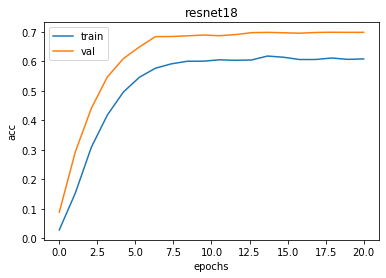

Training model: resnet34 CUDA mem: 91685888
2020-04-05 16:39:13.821775 Phase: train Epoch: 1/20 Loss: 4.6576 Acc: 0.0437
2020-04-05 16:39:20.363049 Phase: val Epoch: 1/20 Loss: 4.0672 Acc: 0.1944
2020-04-05 16:47:17.532182 Phase: train Epoch: 11/20 Loss: 1.4864 Acc: 0.6967
2020-04-05 16:47:24.154552 Phase: val Epoch: 11/20 Loss: 1.0265 Acc: 0.7935
Training complete in 16m 7s
Best val Acc: 0.798689


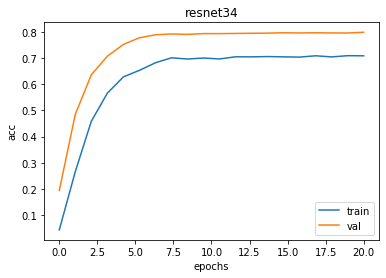

Training model: alexnet CUDA mem: 174840832
2020-04-05 16:54:54.084126 Phase: train Epoch: 1/20 Loss: 3.9717 Acc: 0.1376
2020-04-05 16:54:59.834356 Phase: val Epoch: 1/20 Loss: 2.0974 Acc: 0.4256
2020-04-05 16:58:16.223784 Phase: train Epoch: 11/20 Loss: 1.6012 Acc: 0.5605
2020-04-05 16:58:21.940727 Phase: val Epoch: 11/20 Loss: 1.2326 Acc: 0.6373
Training complete in 6m 45s
Best val Acc: 0.644620


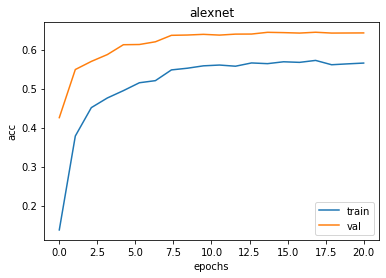

Training model: squeezenet CUDA mem: 461288448
2020-04-05 17:01:53.485148 Phase: train Epoch: 1/20 Loss: 4.8419 Acc: 0.0113
2020-04-05 17:01:59.676793 Phase: val Epoch: 1/20 Loss: 4.7869 Acc: 0.0127
2020-04-05 17:07:44.095977 Phase: train Epoch: 11/20 Loss: 3.8460 Acc: 0.1317
2020-04-05 17:07:50.147261 Phase: val Epoch: 11/20 Loss: 3.5581 Acc: 0.1678
Training complete in 11m 59s
Best val Acc: 0.232742


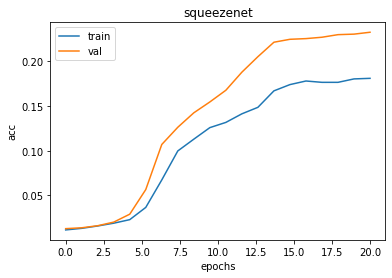

Training model: shufflenet CUDA mem: 6468608
2020-04-05 17:13:41.419259 Phase: train Epoch: 1/20 Loss: 4.7881 Acc: 0.0061
2020-04-05 17:13:48.086077 Phase: val Epoch: 1/20 Loss: 4.7878 Acc: 0.0062
2020-04-05 17:17:33.330584 Phase: train Epoch: 11/20 Loss: 4.7851 Acc: 0.0093
2020-04-05 17:17:39.947873 Phase: val Epoch: 11/20 Loss: 4.7847 Acc: 0.0087
Training complete in 7m 38s
Best val Acc: 0.009063


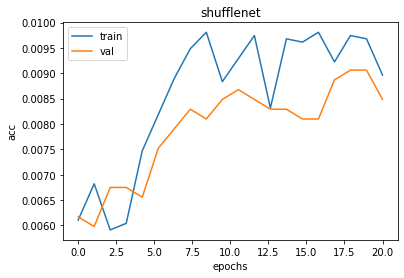

In [15]:
# resnet18 best for 10 epochs
# resnet34 best for 100 epochs
pretrained = ["resnet18", "resnet34", "alexnet", "squeezenet", "shufflenet"]
print("Starting to train models: CUDA mem:", torch.cuda.memory_allocated())
for model_name in pretrained:
    print("Training model:", model_name, "CUDA mem:", torch.cuda.memory_allocated())
    model = adapt_model(model_name)
    model.to(device)
    opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
    model_ft = train_model(model, loss_func, opt, exp_lr_scheduler, num_epochs=epochs, model_name = model_name)
    del model_ft
    del exp_lr_scheduler
    del opt
    torch.cuda.empty_cache()